0
Test 0, theta: [270.], theta_hat: [348.], err: 78.0
1
Test 1, theta: [102.], theta_hat: [356.], err: 106.0
2
Test 2, theta: [358.], theta_hat: [356.], err: 2.0
3
Test 3, theta: [248.], theta_hat: [356.], err: 108.0
4
Test 4, theta: [164.], theta_hat: [358.], err: 166.0
5
Test 5, theta: [112.], theta_hat: [358.], err: 114.0
6
Test 6, theta: [162.], theta_hat: [350.], err: 172.0
7
Test 7, theta: [314.], theta_hat: [358.], err: 44.0
8
Test 8, theta: [200.], theta_hat: [358.], err: 158.0
9
Test 9, theta: [296.], theta_hat: [358.], err: 62.0
10
Test 10, theta: [14.], theta_hat: [358.], err: 16.0
11
Test 11, theta: [150.], theta_hat: [246.], err: 96.0
12
Test 12, theta: [124.], theta_hat: [358.], err: 126.0
13
Test 13, theta: [216.], theta_hat: [346.], err: 130.0
14
Test 14, theta: [58.], theta_hat: [356.], err: 62.0
15
Test 15, theta: [6.], theta_hat: [358.], err: 8.0
16
Test 16, theta: [280.], theta_hat: [122.], err: 158.0
17
Test 17, theta: [228.], theta_hat: [272.], err: 44.0
18
Test 1

array([[ 39.],
       [127.],
       [  1.],
       [ 54.],
       [ 97.],
       [123.],
       [ 94.],
       [ 22.],
       [ 79.],
       [ 31.],
       [172.],
       [ 48.],
       [117.],
       [ 65.],
       [149.],
       [176.],
       [ 79.],
       [ 22.],
       [149.],
       [107.]])

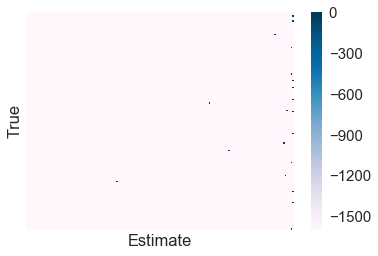

In [6]:
import numpy as np
import math 
import scipy
import scipy.signal

from itertools import combinations

from google.protobuf import text_format

import itertools

import logging
import os
import sys
import datetime
import seaborn as sns
from matplotlib import pyplot as plt

sns.set_style("whitegrid")
sns.set(font_scale=1.5) 
cmap = "PuBu"

# MAYBE TO CHANGE add same noise everywehre

def whiteNoise(numberOfSources, starting_frequency = 0):
    ''' White noise localization 
    
     Input:
       - 
       - 
       - 
       - 
    
     Output:
       - 
    '''
    outpath = os.path.join('output',  '{:%Y%m%d_%H%M}'.format(datetime.datetime.now()))
    if not os.path.exists(outpath):
        os.makedirs(outpath)
    
    logfile = os.path.join(outpath, "log.txt")

    logging.basicConfig(filename=logfile, format='%(asctime)s %(message)s', level=logging.INFO)
    logger = logging.getLogger(__name__)
    
    f0 = starting_frequency #starting frequency index
    step = 1 #discretization (for now we want to use the 180 angles so we keep it like that)
    n_samples = 1024
    # maybe to add - starting frequency (f0)
    Fn = n_samples/2. +  1 #number of frequencies in spectrogram 
    # noise in dB
    SNR = 0

    
    '''
    Generation H_theta omnidirectional (instead of load)
    '''

    # Decided by me. Should it be random ? or special ones ? 
    # If we want less mics put less positions
    mic_positions = np.array([(1,0), (0,1), (0,0), (-1,0), (0,-1)])

    number_mics = mic_positions.shape[0]
    N = number_mics


    # We want a discretization of every 2 degrees
    step_angle = 2
    number_angles = int(360/step_angle)
    # the different frequencies
    c = 340.29 #speed of sound 340.29 m/s
    sample_rate = 8000 # The maximum frequency we want to use
    freq = np.fft.rfftfreq(n_samples, d=1./(2*sample_rate))
    number_frequencies = int(n_samples/2 + 1)


    H_theta_freq_total = np.zeros((number_mics, number_angles, number_frequencies), dtype=complex)


    for index_H in range(number_angles):
        thetaAngle = step_angle*index_H
        # We calculate the distances between the source and the different microphones
        # This is an hypothetic distance, as the micrphone is considered "far away", using the direction of the signal

        horizontalDistance = mic_positions[:,0] - math.cos(math.radians(thetaAngle))
        verticalDistance = mic_positions[:,1] - math.sin(math.radians(thetaAngle))
        distanceSourceMicrophones = np.sqrt(np.power(horizontalDistance, 2) + np.power(verticalDistance, 2))

        tau = distanceSourceMicrophones/c

        tau_reshaped = np.transpose(np.array([tau,]*freq.shape[0]))
        freq_reshaped = np.array([freq,]*tau.shape[0])

        H_theta_freq_total[:,index_H,:] = np.exp(-freq_reshaped*1j*tau_reshaped)

    number_angles = H_theta_freq_total.shape[1]
    number_mics = H_theta_freq_total.shape[0]

    # time 
    theta_transition = np.transpose(H_theta_freq_total)
    H_theta_time_total = np.zeros((n_samples, number_angles, number_mics))
    for n_mic in range(number_mics):
        H_theta_time_total[:,:,n_mic] = np.transpose(np.fft.irfft(np.transpose(theta_transition[:,:,n_mic]), n_samples))
            
    # freq stacked
    H_theta_freq_stacked = H_theta_freq_total[0,:,:]
    for n_mic in range(1, number_mics):
        H_theta_freq_stacked = np.append(H_theta_freq_stacked, H_theta_freq_total[n_mic,:,:], axis=1)

    '''
    End Generation H_theta omnidirectional
    '''

    
    
    dev = 'Omnidirectional' # Change if using Kemar or lego
    logger.info('Load transfer functions %s'%dev)
    '''
    H_theta_time_total = np.load('kemar_h_theta_1deg_time.npy')    
    
    print(H_theta_time_total.shape)
    '''
    Df = H_theta_time_total[:, ::step, 0].shape[1] #number of directions for a fine discretization
            
    anglesf = np.arange(Df, dtype=np.int64)*360./Df # list of angles in degrees

        
    number_microphones = H_theta_time_total.shape[2]
        
    '''
    H_theta_freq_first_mic = np.fft.rfft(np.transpose(H_theta_time_total[:, :, 0]), n_samples)
    H_theta_freq_first_mic = H_theta_freq_first_mic[:,f0:] 

    H_theta_freq_stacked = H_theta_freq_first_mic
    
    for i in range(1, number_microphones):
        H_theta_freq_one_mic_for_stacked = np.fft.rfft(np.transpose(H_theta_time_total[:, :, i]), n_samples)
        H_theta_freq_one_mic_for_stacked = H_theta_freq_one_mic_for_stacked[:,f0:] 
        H_theta_freq_stacked = np.append(H_theta_freq_stacked, H_theta_freq_one_mic_for_stacked, axis=1)

    print(H_theta_freq_stacked.shape)
    '''
    #coarse discretization,  model, no need of the ::step because already done in time 
    H_theta_freq_stacked = np.transpose(H_theta_freq_stacked)
    [F, D] = H_theta_freq_stacked.shape 
    #F: number of frequencies,  D: number of directions
    #print(F,D)
    #print(H_theta_freq_stacked)
    
    #H_theta_freq_stacked = np.transpose(H_theta_freq_stacked)
    
    #length of the convolution might have to adapt something
    obs_len = n_samples + H_theta_time_total[:,:,0].shape[0] - 1
        
    numAngles = H_theta_time_total.shape[1]
    runs = 20
    J = numberOfSources
    conf_matrix = np.zeros((numAngles, numAngles)) #confusion  matrix
    
    #TO ADAPT for the runs value and maybe microphones value
    err_per_source = np.zeros((runs, J))
    min_err_per_source = np.zeros((runs, J))
    
    logger.info('Number of runs %s'%(runs))
    logger.info('Noise in decibel %s'%(SNR))
    logger.info('Number of sources %s'%(J))
    logger.info('Number of samples %s'%(n_samples))    
    #To keep the minimal error between each source at each run 
    min_err_by_run = np.zeros(runs)

    for rns in range(runs):
        print(rns)
        #choose the directions randomly on the fine grid
        theta = np.random.choice(range(Df), numberOfSources, replace=False)
        Source_signal = np.zeros((n_samples, J)) #list of source signals
        for j in range(J):
            Source_signal[:, j] = np.random.randn(n_samples) #source in time: random gaussian signal 
        # First Mic 
        
        #recorded time domain signal
        yt = np.zeros((obs_len, )) 

        for j in range(J):
            #source signal convolved with corresponding directional response
            first_H_theta =H_theta_time_total[:,:,0]
            yt += np.convolve(Source_signal[:, j], first_H_theta[:, theta[j]]) 

        # Generate noise at required SNR    
        sig_norm = np.linalg.norm(yt)
        noise_t = np.random.randn(obs_len, ) #additive gaussian noise
        noise_norm = sig_norm/(10.**(SNR/20.))
        noise_t = noise_norm*noise_t/np.linalg.norm(noise_t)

        yt += noise_t #noisy signal

        (freq_samples, seg_times, y) = scipy.signal.stft(yt, Fn, nperseg=n_samples)
        #print(y)
        #Other Mics 
        
        for i in range(1, number_microphones):
            #recorded time domain signal
            yt = np.zeros((obs_len, )) 

            for j in range(J):
                #source signal convolved with corresponding directional response
                first_H_theta =H_theta_time_total[:,:,i]
                yt += np.convolve(Source_signal[:, j], first_H_theta[:, theta[j]]) 

            # Generate noise at required SNR    
            sig_norm = np.linalg.norm(yt)
            noise_t = np.random.randn(obs_len, ) #additive gaussian noise
            noise_norm = sig_norm/(10.**(SNR/20.))
            noise_t = noise_norm*noise_t/np.linalg.norm(noise_t)

            yt += noise_t #noisy signal

            (freq_samples, seg_times, toAdd) = scipy.signal.stft(yt, Fn, nperseg=n_samples)
            y = np.append(y,toAdd,axis=0)
        #print("NEW Y")
        #print(y.shape)

        

        y_mean = np.mean(np.abs(y)**2, axis=1) #mean power frame
        y_mean = y_mean/np.linalg.norm(y_mean) #normalize the observation

        # Exhaustive search algorithm

        # Initialize variables
        best_ind = np.inf #index corresponding to best direction tuple
        smallest_norm = np.inf #smallest projection error
        best_dir = theta #best direction tuple

        # Search all combinations
        pairs2 = combinations(range(D), J)
        for q2, d2 in enumerate(pairs2): 
            Bj = np.abs(H_theta_freq_stacked[:, d2])**2 #vectors in current guess
            Pj = Bj.dot(np.linalg.pinv(Bj)) #projection matrix

            proj_error = np.linalg.norm((np.eye(F) - Pj).dot(y_mean)) #projection error

            if proj_error <= smallest_norm:
                smallest_norm = proj_error
                best_ind = q2
                best_dir = d2
        theta_hat = step*np.array(best_dir) #map coarse index to fine index
        #print(theta)
        #print(theta_hat)
        min_err, best_perm = calculate_angle_error(theta, theta_hat, anglesf) #calculate error between chosen and true directions
        conf_matrix[theta, best_perm] += 1
        
        min_err_by_run[rns] = min_err

        for src_j in range(J): #error per source
            err_per_source[rns, src_j] = np.sum(np.absolute(((best_perm[src_j]-theta[src_j]+180) % 360)-180))
            
        print('Test %s, theta: %s, theta_hat: %s, err: %s'%(rns, anglesf[theta], anglesf[best_perm], min_err))
        logger.info('Test %s, theta: %s, theta_hat: %s, err: %s'%(rns, anglesf[theta], anglesf[best_perm], min_err))
    logger.info('Err_per_source average: %s, median: %s, Min_err average: %s, median: %s'%(np.mean(err_per_source, axis=0), np.median(err_per_source, axis=0), np.mean(min_err_by_run, axis=0), np.median(min_err_by_run, axis=0)))
    logger.info('Err_per_source max: %s, min: %s, Min_err max: %s, min: %s'%(np.max(err_per_source, axis=0), np.min(err_per_source, axis=0), np.max(min_err_by_run, axis=0), np.min(min_err_by_run, axis=0)))
    hm = sns.heatmap(20*np.log10(conf_matrix+1e-80), cmap=cmap, xticklabels=False,  yticklabels=False)
    plt.xlabel('Estimate')
    plt.ylabel('True')
    plt.savefig(os.path.join(outpath, 'conf_matrix.png'))
    return err_per_source

# Taken from https://github.com/swing-research/scatsense/blob/master/core/signal.py 
# Code written by Dalia El Badawy
def calculate_angle_error(theta,theta_hat,angles):
    '''Average localization error in degrees (modulo 360)
    Also finds the best permutation that gives the lowest error
    Input:
        theta: array of true indices
        theta_hat: array of estimated indices
        angles: list of angles in degrees
    '''
    J = len(theta) #number of sources
    all_perms = itertools.permutations(theta_hat) #all permutations
    min_err = np.Inf

    for beta in all_perms:
        curr_err = np.sum(np.absolute(((angles[np.array(beta)]-angles[theta]+180) % 360)-180))*1./J;
        if curr_err<min_err:
            min_err = curr_err
            perm = np.array(beta)
            
    return min_err,perm


whiteNoise(1)
